# Function optimize_ga with ∂a∂i for (YRI, CEU) inference

It is example from [∂a∂i](https://bitbucket.org/gutenkunstlab/dadi/). In original example close to optimal parameters are pertrubed and then local search (optimize_log, optimize_powell etc.) is launched.

In our modification of this example here we use global search - Genetic Algorithm (optimize_ga) from [GADMA](https://github.com/ctlab/GADMA) software.

You can find original python code [here](https://bitbucket.org/gutenkunstlab/dadi/src/master/examples/YRI_CEU/YRI_CEU.py) (`dadi/examples/YRI_CEU/YRI_CEU.py` file)

## Imports

In [1]:
import dadi
import gadma
%matplotlib inline

## Data

Data was build originally for paper [Gutenkunst et al. 2009](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000695).

It is 20x20 spectrum for two populations:

* YRI - Yoruba in Ibadan, Nigeria
* CEU - Utah Residents (CEPH) with Northern and Western European Ancestry

In [2]:
data = dadi.Spectrum.from_file("YRI_CEU.fs")
ns = data.sample_sizes
print(f"Size of spectrum: {ns}")

Size of spectrum: [20 20]


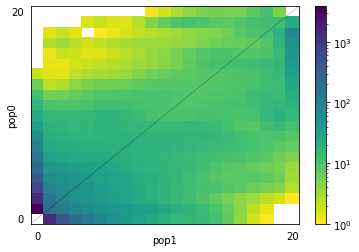

In [3]:
dadi.Plotting.plot_single_2d_sfs(data, vmin=1.0)

## Grid points

∂a∂i needs grid points for evaluations:

In [4]:
# These are the grid point settings will use for extrapolation.
pts = [40,50,60]

## Demographic model

Demographic model is saved in `demographic_models_dadi.py` as ``model_func`` function. But we also put it here:

In [5]:
import numpy
import dadi

def model_func(params, ns, pts):
    """
    Model with growth, split, bottleneck in pop2, exp recovery, migration

    nu1F: The ancestral population size after growth. (Its initial size is
          defined to be 1.)
    nu2B: The bottleneck size for pop2
    nu2F: The final size for pop2
    m: The scaled migration rate
    Tp: The scaled time between ancestral population growth and the split.
    T: The time between the split and present

    n1,n2: Size of fs to generate.
    pts: Number of points to use in grid for evaluation.
    """

    nu1F, nu2B, nu2F, m, Tp, T = params
    # Define the grid we'll use
    xx = yy = dadi.Numerics.default_grid(pts)

    # phi for the equilibrium ancestral population
    phi = dadi.PhiManip.phi_1D(xx)
    # Now do the population growth event.
    phi = dadi.Integration.one_pop(phi, xx, Tp, nu=nu1F)

    # The divergence
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    # We need to define a function to describe the non-constant population 2
    # size. lambda is a convenient way to do so.
    nu2_func = lambda t: nu2B*(nu2F/nu2B)**(t/T)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1=nu1F, nu2=nu2_func, 
                                    m12=m, m21=m)

    # Finally, calculate the spectrum.
    sfs = dadi.Spectrum.from_phi(phi, ns, (xx,yy))
    return sfs

We can import it from file by:

In [6]:
from demographic_models_dadi import model_func as func

or use directly from our notebook:

In [7]:
func = model_func

## Inference

Now we will infer parameters for this demographic history and loaded data.

In [8]:
# Now let's optimize parameters for this model.

# The upper_bound and lower_bound lists are for use in optimization.
# Occasionally the optimizer will try wacky parameter values. We in particular
# want to exclude values with very long times, very small population sizes, or
# very high migration rates, as they will take a long time to evaluate.
# Parameters are: (nu1F, nu2B, nu2F, m, Tp, T)
par_labels = ('nu1F', 'nu2B', 'nu2F', 'm', 'Tp', 'T')
upper_bound = [100, 100, 100, 10, 3, 3]
lower_bound = [1e-2, 1e-2, 1e-2, 0, 0, 0]

# Make the extrapolating version of our demographic model function.
func_ex = dadi.Numerics.make_extrap_log_func(func)

# Run our optimization
# For more information: help(gadma.Inference.optimize_ga)
# It is test optimization so only 10 iterations of global optimization
# (ga_maxiter) and 1 iteration of local (ls_maxiter) are run.
# For better optimization set those number to greater values or to None.
print('Beginning optimization ************************************************')
result = gadma.Inference.optimize_ga(data=data,
                                     model_func=func_ex,
                                     engine='dadi',
                                     args=(pts,),
                                     p_ids = par_labels,
                                     lower_bound=lower_bound,
                                     upper_bound=upper_bound,
                                     local_optimizer='Powell_log',
                                     ga_maxiter=10,
                                     ls_maxiter=1)
print('Finshed optimization **************************************************')

Beginning optimization ************************************************
--Start global optimization Genetic_algorithm--


2998.5798028627855 15684.69145058756
Generation #0.
Current generation of solutions:
N	Value of fitness function	Solution
0	-1701.826817	(nu1F=2.30421,	nu2B=2.06258,	nu2F=0.45752,	m=0.75996,	Tp=1.18187,	T=0.86968)	r
1	-1729.977101	(nu1F=2.8046,	nu2B=0.03398,	nu2F=0.56888,	m=1.29198,	Tp=0.54352,	T=1.27484)	r
2	-3429.804929	(nu1F=10.07386,	nu2B=2.30486,	nu2F=0.42512,	m=0.83356,	Tp=0.83459,	T=0.9573)	r
3	-3553.704116	(nu1F=0.57483,	nu2B=0.08977,	nu2F=0.28265,	m=1.15827,	Tp=1.12788,	T=1.00575)	r
4	-3584.960802	(nu1F=2.26739,	nu2B=3.09241,	nu2F=2.52953,	m=0.58835,	Tp=0.88652,	T=0.77567)	r
5	-3675.524195	(nu1F=12.18778,	nu2B=3.09972,	nu2F=0.33028,	m=1.00913,	Tp=1.11375,	T=0.3531)	r
6	-3792.617760	(nu1F=0.69454,	nu2B=0.68659,	nu2F=1.04326,	m=1.37447,	Tp=1.07923,	T=1.16278)	r
7	-4259.763741	(nu1F=0.41307,	nu2B=0.28107,	nu2F=0.18045,	m=1.40936,	Tp=1.59377,	T=1.17211)	r
8	-4300.191417	(nu1F=0.59633,	nu2B=1.9406,	nu2F=0.38285,	m=0.45428,	Tp=0.75365,	T=0.33004)	r
9	-4316.308906	(nu1F=3.35194,	nu2B

Generation #7.
Current generation of solutions:
N	Value of fitness function	Solution
0	-1379.451604	(nu1F=2.30421,	nu2B=2.06258,	nu2F=0.40953,	m=1.69576,	Tp=0.54352,	T=0.86968)	mm
1	-1421.483902	(nu1F=2.30421,	nu2B=2.06258,	nu2F=0.56888,	m=1.29198,	Tp=0.54352,	T=0.86968)	c
2	-1481.222311	(nu1F=1.9016,	nu2B=2.06258,	nu2F=0.56888,	m=1.45384,	Tp=0.54352,	T=0.86968)	mm
3	-3443.242136	(nu1F=6.55397,	nu2B=1.64121,	nu2F=0.23611,	m=0.79503,	Tp=1.01632,	T=0.47258)	r
4	-4238.287643	(nu1F=13.82932,	nu2B=0.52445,	nu2F=1.76065,	m=1.12997,	Tp=0.88447,	T=0.63745)	r
5	-6199.437036	(nu1F=1.49263,	nu2B=0.10287,	nu2F=0.42053,	m=0.36103,	Tp=0.54352,	T=0.52632)	c
6	-6341.457145	(nu1F=6.88227,	nu2B=0.10287,	nu2F=0.56888,	m=0.36103,	Tp=0.54352,	T=1.1935)	m
7	-9146.318921	(nu1F=4.05271,	nu2B=6.0622,	nu2F=0.19563,	m=0,	Tp=1.74888,	T=0.85791)	c
8	-10749.801271	(nu1F=0.65262,	nu2B=10.16508,	nu2F=0.56506,	m=0,	Tp=1.43428,	T=0.56536)	mmm
9	-19462.131920	(nu1F=0.57119,	nu2B=10.16508,	nu2F=0.56506,	m=0,	Tp=1.06285,	

29	-1807.5156600216585	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=0.78362,	Tp=0.54352,	T=0.86968)	
30	-1454.6104282471256	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=2.13011,	Tp=0.54352,	T=0.86968)	
31	-1216.5164931025915	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.44462,	Tp=0.54352,	T=0.86968)	
32	-1216.3828121502381	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.45754,	Tp=0.54352,	T=0.86968)	
33	-1216.3737651390086	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.45812,	Tp=0.54352,	T=0.86968)	
34	-1251.1253085831238	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.68526,	Tp=0.54352,	T=0.86968)	
35	-1221.4720803645298	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.54102,	Tp=0.54352,	T=0.86968)	
36	-1217.136792008684	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.48925,	Tp=0.54352,	T=0.86968)	
37	-1216.5009769324383	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.46993,	Tp=0.54352,	T=0.86968)	
38	-1216.3868222564906	(nu1F=1.98685,	nu2B=0.6281,	nu2F=0.50579,	m=1.46262,	Tp=0.54352,	T=0.86968)	
3

In [9]:
popt = result.x
print(f'Found parameters: {popt}')
print(f'With log-likelihood: {result.y}')

# Now we can compare our parameters with those that were obtained before:
print('\nFrom Gutenkunst et al 2009:')
# These are the actual best-fit model parameters, which we found through
# longer optimizations and confirmed by running multiple optimizations.
# We'll work with them through the rest of this script. 
popt = [1.881, 0.0710, 1.845, 0.911, 0.355, 0.111]
print('Best-fit parameters: {0}'.format(popt))

# Calculate the best-fit model AFS.
model = func_ex(popt, ns, pts)
# Likelihood of the data given the model AFS.
ll_model = dadi.Inference.ll_multinom(model, data)
print('Maximum log composite likelihood: {0}'.format(ll_model))
# The optimal value of theta given the model.
theta = dadi.Inference.optimal_sfs_scaling(model, data)
print('Optimal value of theta: {0}'.format(theta))

Found parameters: [1.9868528725580605 0.6281033050618842 0.5057936159267086
 1.4580765859361928 2.7945929091077765e-17 0.4886353404838611]
With log-likelihood: -1184.4413687280955

From Gutenkunst et al 2009:
Best-fit parameters: [1.881, 0.071, 1.845, 0.911, 0.355, 0.111]
Maximum log composite likelihood: -1066.3460755934125
Optimal value of theta: 2749.285796480555


## Plotting

Now we could draw some plots for model with best parameters.

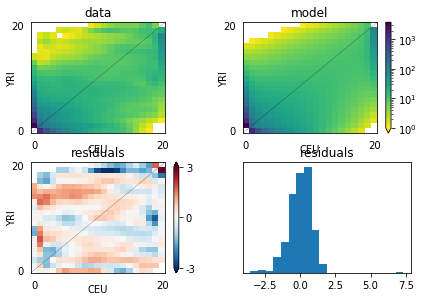

In [10]:
# Plot a comparison of the resulting fs with the data.
import pylab
pylab.figure(1)
dadi.Plotting.plot_2d_comp_multinom(model, data, vmin=1, resid_range=3,
                                    pop_ids =('YRI','CEU'), show=True)